<h2> Model of dynamics in a reservoir of excitons and free carriers </h2>
<br>
<div style="display: flex;">
<div style="width: 55%">
В нашей статье [<a \href="https://journals.aps.org/prb/abstract/10.1103/PhysRevB.104.035414"> PhysRevB.104.035414(2021) </a>] исследовался резервуар темных экситонов с большими волновыми векторами в плоскости квантовой ямы. С помощью методики накачка-зондирования измерялась динамика $\Delta \hbar \Gamma$ (фотоиндуцированное нерадиационное уширение резонанса тяжелого экситона, см. рис. 1). 
</div>

<div style="flex: auto; margin-left: 15px">
<figure>
<img src="images/figure1.png"
     style="width: 400px;"
     alt="scheme">
<figcaption style="width: 400px;"> Fig.1 - Dynamics of the nonradiative broadening of the Xhh resonance: experiment (blue dots) and simulation (red line). Caption shows the reflectivity spectrum of the sample with 14nm GaAs/AlGaAs quantum well. Vaules of $\Delta \hbar \Gamma$ are extracted from preprocessing of the reflectivity spectra. </figcaption>
</figure>
 
<br>    
    
<figure>
<img src="images/figure2.png"
     style="width: 300px;"
     alt="scheme">
<figcaption style="width: 400px;"> Fig.2 - Scheme of the dynamic processes. Dispersion of heavi- and light-hole excitons (Xhh and Xlh) in the quantum well plane are shown by parabolas. Transitions and their rates are shown by arrows and greek letters, blue letters are exciton and charge carrier densities. </figcaption>
</figure>
</div>
</div>

<div>
<h3> System of equations </h3>
<br>
$
\large
n_{x}^{hot} = N_0 (1-k) e ^{-\gamma_{d} t} \\ % (1 - k)
\large
\begin{cases}
\begin{align}
&\dot{n} = \gamma_d n_{x}^{hot} - \kappa_{ex} n^2 \\
&\dot{n}_x = \kappa_{ex} n^2 - 2 \kappa_c n n_x,\\
\end{align}
\end{cases}
$
<p><b> where </b></p>
    
$
\large
\begin{align}
&n_{x}^{hot}~\small \text{— areal density of hot dark excitons} \\ 
&n~\small \text{— areal density of electrons (holes)} \\
&n_x~\small \text{— areal density of (cold) dark excitons} \\
\end{align}
$
<p><b> Initial values: </b></p>
    
$
\large
\begin{align}
&n(0) = 0 \\ 
&n_x(0) = N_{bgr} + k \cdot N_0 \\
\end{align}
$
<p><b> Calculated nonradiative broadening: </b></p>
    
$
\large
\Delta \hbar \Gamma = \sigma (2n + n_x + n_{x}^{hot})
$
<p><b> Fitting parameters </b></p>

$
\large
\begin{align}
&N_0~\small \text{— initial density of dark excitons scattered to the reservoir after the pump pulse absorption} \\ 
&k~\small \text{— fraction of cold excitons} \\
&\gamma_d~\small \text{— exciton dissociation rate} \\
&\kappa_{ex}~\small \text{— association rate of electrons and holes into excitons} \\
&\kappa_{c}~\small \text{— scattering rate of dark excitons into the light cone by charge carriers} \\
\end{align}
$
<p><b> Consts: </b></p>

$
\large
\begin{align}
&\sigma \equiv 3~\small \text{— broadening cross-section} \\ 
&N_{bgr} \equiv \Delta \hbar \Gamma_{neg. delay} \sigma ~\small \text{— areal density of excitons in the dark reservoir at negative delays} \\
&\Delta \hbar \Gamma_{neg. delay}~\small \text{— experimentally defined nonradiative broadening at small negative delays} \\
\end{align}
$
</div>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 

import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interactive
from IPython.display import display

import pandas as pd
import numpy as np

from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit


### Experiemental data: pump into the state of light exciton (LX) with power P=200$\mu$W 


In [2]:
# load experimental data
data = np.loadtxt('data/11.06_LX_200mkW.txt') 
delay = data[:, 0]  # delay between pump and probe in picoseconds
delay = delay - delay[167]  # adjust zero delay
hgamma = data[:, 1]  # nonradiative broadening of heavy exciton
neg = hgamma[25:100].mean()  # broadening at negative delays

nstart = np.argmin(abs(delay - 42))  # start fit from delay=42 ps
nend = -10  # last point of fit 
sigm = 3  # broadening cross-section

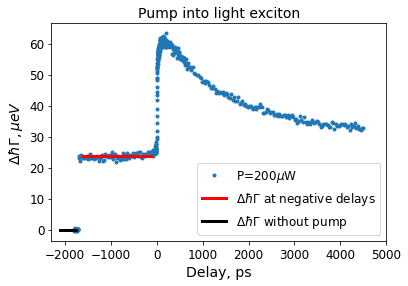

In [3]:
# plot experimental data
plt.figure(figsize=(6, 4))
plt.plot(delay, hgamma, '.', label='P=200$\mu$W')
plt.plot([delay[25], delay[100]], [neg, neg], 
         'r-', linewidth=3, label='$\Delta\hbar\Gamma$ at negative delays')
plt.plot([delay[0]-300, delay[10]], [0, 0], 
         'k-', linewidth=3, label='$\Delta\hbar\Gamma$ without pump')
plt.title('Pump into light exciton', fontsize=14)
plt.xlabel('Delay, ps', fontsize=14)
plt.ylabel('$\Delta\hbar\Gamma, \mu eV$', fontsize=14)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.xlim([-2300, 5000]);

In [4]:
def ex_(A, dec, t):
    return A*np.exp(-dec*t)

In [5]:
def ivp(delay, N0, k, gd, kex, kc, b):
    '''
    solve initial value problem
    model equations are set here
    '''
    
    def scatter(t, y, N0, k, gd, kex, kc):
        nx_hot = ex_(N0*(1-k), gd, t)
        ne, nh, nx = y
     
        return [gd*nx_hot - kex*ne*nh, 
                gd*nx_hot - kex*ne*nh, 
                kex*ne*nh - kc*nx*(ne+nh)]
    
    n0 = [0, 0, b + N0*k]
    tspan = (0, delay[-1])
    fun = lambda t, y: scatter(t, y, N0, k, gd, kex, kc)
    sol = solve_ivp(fun, tspan, n0, t_eval=delay)
    
    return sol

In [6]:
def broad(delay, hgamma, neg, N0, k, gd, kex, kc, 
          sigm=sigm, nstart=nstart, nend=nend,
          xlim=[-1000, 5000], ylim=[-10, 75]):
    '''
    simulate and plot the results
    nstart - first point of fit
    nend - last point of fit
    '''
    # experimental data for fit
    delay_fit = delay[nstart:nend]
    hgamma_fit = hgamma[nstart:nend]
    
    # simulation
    t = np.linspace(0, delay_fit[-1], 1000)
    sol = ivp(t, N0, k, gd, kex, kc, neg/sigm)  # solve initial value problem
    y = sol.y
    
    # particle densities from simulation
    nx_hot = ex_(N0*(1-k), gd, t)    
    ne = y[0, :]
    nh = y[1, :]
    nx = y[2, :]
    
    # extend results for previous laser puls to show goodness of simulation for negative delays
    t_2p = np.r_[t-13000, t]  # concat delays. Assume that repetition period is 13000 ps
    ne_2p = np.r_[ne, ne]  # for the steady state we can just repeat our results 
    nh_2p = np.r_[nh, nh]
    nx_2p = np.r_[nx, nx]
    nx_hot_2p = np.r_[nx_hot, nx_hot]
    
    results = {
        'time': t_2p,
        'ne': sigm*ne_2p,
        'nh': sigm*nh_2p,
        'nx': sigm*nx_2p,
        'nx_hot': sigm*nx_hot_2p,
        'delta_hGamma': sigm*(ne_2p + nh_2p + nx_2p + nx_hot_2p),
        'PL': kc*(ne_2p + nh_2p)*nx_2p 
    }
    
    params = {
        'N0': N0,
        'k': k,
        'gd': gd, 
        'kex': kex, 
        'kc': kc,
        'sigm': sigm
    }
    
    # plotting
    
    font = {'family': 'serif',
            'weight': 'normal',
            'size': 16}
    
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    
    plt.plot(delay, hgamma, '.', label='Data')
    plt.plot(t_2p, sigm*nh_2p, '-m', linewidth=2, label='e,h')
    plt.plot(t_2p, sigm*nx_2p, '-', color='#808800', linewidth=2, label='dark X')
    plt.plot(t_2p, sigm*nx_hot_2p, '-', color='#800000', linewidth=2, label='hot-X')
    plt.plot(t_2p, sigm*(ne_2p + nh_2p + nx_2p + nx_hot_2p), '-k', linewidth=2, label='broadening')
      
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.locator_params(axis='x', nbins=6)
    plt.xlabel('Delay, ps', fontdict=font)
    plt.ylabel(r'$\Delta\hbar\Gamma$, $\mu$eV', fontdict=font)
    plt.legend(loc=1, fontsize=12)
    
    return results, params

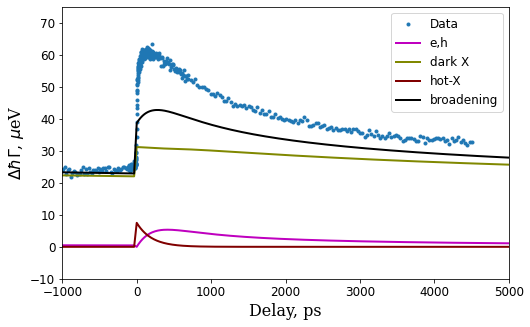

In [7]:
# simulate
N0, k, gd, kex, kc = 5, 0.5, 5e-03, 5e-04, 5e-05  # initial values
results = broad(delay, hgamma, neg, N0, k, gd, kex, kc, 
                nstart=210, nend=-10,
                xlim=[-1000, 5000], ylim=[-10, 75]);

In [8]:
def go_ivp(delay, hgamma, neg, N0, k, gd, kex, kc, sigm=sigm, nstart=nstart, nend=nend):
    '''
    find optimal parameters of the model to simulate the experimental data
    '''
    # experimental data for fit
    delay_fit = delay[nstart:nend]
    hgamma_fit = hgamma[nstart:nend]

    def crv_fitter(xdata, P, k, gd, kex, kc):
        sol = ivp(xdata, P, k, gd, kex, kc, neg/sigm)
        y = sol.y
        t = sol.t
        nx_hot = ex_(P*(1-k), gd, t)
        return sigm*(y[0, :] + y[1, :] + y[2, :] + nx_hot)

    p0 = [N0, k, gd, kex, kc] 
    popt, pcov = curve_fit(crv_fitter, delay_fit, hgamma_fit, p0,
                           bounds=([0.01, 0, 0, 0, 0], [100, 1, 1, 1, 1]),
                           method='trf')

    return popt, pcov

In [9]:
# user interface
N0w = widgets.FloatSlider(
    value=N0, min=0.01, max=100, step=0.01, continuous_update=False, readout_format='.2f')

kw = widgets.FloatSlider(
    value=k, min=0, max=1, step=0.01, continuous_update=False, readout_format='.2f')

gdw = widgets.FloatSlider(
    value=gd, min=1e-6, max=1, step=1e-6, continuous_update=False, readout_format='.2e')

kexw = widgets.FloatSlider(
    value=kex, min=1e-6, max=1, step=1e-6, continuous_update=False, readout_format = '.3e')

kcw = widgets.FloatSlider(
    value=kc, min=1e-8, max=1, step=1e-8, continuous_update=False, readout_format='.3e')

def fit(b):
    popt, pcov = go_ivp(delay, hgamma, neg, N0w.value, kw.value, gdw.value, kexw.value, kcw.value)
    N0w.value, kw.value, gdw.value, kexw.value, kcw.value = popt  # update widgets
    print(f'N_0={N0w.value:.3f}, k={kw.value:.2e}, '
          f'gd={gdw.value:.2e}, kex={kexw.value:.2e}, kc={kcw.value:.2e}')

def saving(b):
    results, params = w.result  # solution - densities dynamics
    filename = '_'.join([k+f'_{v:.1g}' for k, v in params.items()])
    df = pd.DataFrame(results)
    
    with open(f'results/{filename}.dat', 'w') as f:
        f.write(f'# parameters of the model\n# {params}\n')
        df.to_csv(f, line_terminator='\n')
        
    print('saved to file')
    
fit_button = widgets.Button(description='Fit', button_style='primary')
fit_button.on_click(fit)

save_button = widgets.Button(description='Save', button_style='success')
save_button.on_click(saving)
    
broad_fun = lambda N0, k, gd, kex, kc: broad(delay, hgamma, neg, N0, k, gd, kex, kc) 
w = interactive(broad_fun, N0=N0w, k=kw, gd=gdw, kex=kexw, kc=kcw)

display(w)
display(fit_button)
display(save_button)



interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='N0', min=0.01, step=0.01), …

Button(button_style='primary', description='Fit', style=ButtonStyle())

Button(button_style='success', description='Save', style=ButtonStyle())

N_0=10.840, k=6.96e-01, gd=6.42e-03, kex=5.58e-04, kc=7.90e-05
